Author: **SrisaicharanVelisetti**

In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from statistics import mean
import torchvision.models as models

# Semantic Segmentation

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.
So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import os 
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path
  
  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")
 
get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

"""Various RGB palettes for coloring segmentation labels."""
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


if torch.cuda.is_available():
  device=torch.device('cuda:0')
  print('Cuda')
else:
  device=torch.device('cpu')
  print('cpu')

cpu


## Code 

### Implement Data Loader for training and validation 

In [ ]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

# You can modify this class 
class VocDataset(Dataset):
  def __init__(self, dir, color_map):
    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=color_map

  def convert_to_segmentation_mask(self,mask):
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
    for label_index, label in enumerate(self.color_map):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

  def __getitem__(self,index):
    image_id=self.files[index]
    image_path=os.path.join(self.images_dir,f"{image_id}.jpg")
    label_path=os.path.join(self.target_dir,f"{image_id}.png")
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(256,256))
    image=torch.tensor(image).float()
    label=cv2.imread(label_path)
    label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
    label=cv2.resize(label,(256,256))
    label = self.convert_to_segmentation_mask(label)
    label=torch.tensor(label).float()
    
    return image,label
    
  def __len__(self):
    return len(self.files)

# Load the dataset
dataset = VocDataset('',VOC_COLORMAP)
# Create a dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
images, labels = next(iter(dataloader))

dataset.__len__()



# Train set and validation set 
train_set,val_set=torch.utils.data.random_split(dataset,[int(len(dataset)*0.9),round(len(dataset)*0.1)+1])
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=10, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)


###2. Define model and training code 
Implementing FCN-32 model. Using an encoder as pretrained model provided by torchvision.       

In [ ]:
import torch
class FCN32(torch.nn.Module):
  def __init__(self, n_classes, pretrained_model):
    super(FCN32, self).__init__()
    self.pretrained_model=pretrained_model
    # encoder
    self.encoder = torch.nn.Sequential(*list(pretrained_model.features.children()))

    self.encoder_classifier = torch.nn.Sequential(
        torch.nn.Conv2d(512, 4096, kernel_size=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Conv2d(4096, 4096, kernel_size=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout()
    )

    # decoder
    self.decoder = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(4096, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(512),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(32, n_classes, kernel_size=1)
    )

  # forward function
  def forward(self, x):
    output = self.encoder(x)
    output = self.encoder_classifier(output)
    output = self.decoder(output)

    # return the predicted label image
    return output

 Training code for the semantic segmentation model. Implment both training and validation parts.  

In [ ]:

import torchvision 
from torch.utils.data import Dataset, DataLoader, random_split
import tqdm
import sklearn.metrics


def metrics(y_pred,y_true):
  y_pred=torch.argmax(y_pred,dim=1)
  y_true=torch.argmax(y_true,dim=1)
  iou=sklearn.metrics.jaccard_score(y_true.flatten(),y_pred.flatten(),average='weighted')
  return iou

def train(model,optim,loss_f,epochs,scheduler,path_for_models):
  try:
    os.mkdir(path_for_models)
  except:
    path_for_models=path_for_models

  min_iou=0.3
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  for epoch in (range(epochs)):
    for (X_train,y_train) in train_loader:
      X_train = X_train.permute(0, 3, 1, 2)
      y_train = y_train.permute(0, 3, 1, 2)
      y_pred=model(X_train)
      loss=loss_f(y_pred,y_train)

      optim.zero_grad()
      loss.backward()
      optim.step()
    ious=[]
    val_losses=[]
    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(val_loader):
        X_test,y_test=X_test.to(device),y_test.to(device)
        X_test = X_test.permute(0, 3, 1, 2)
        y_test = y_test.permute(0, 3, 1, 2)
        y_val=model(X_test)
        val_loss=loss_f(y_val,y_test)
        val_losses.append(val_loss)
        iou_= metrics(y_val,y_test)
        ious.append(iou_)
      ious=torch.tensor(ious)
      val_losses=torch.tensor(val_losses)
      scheduler.step(val_losses.mean())
      if ious.mean() > min_iou:
        min_iou=ious.mean()
        torch.save(model.state_dict(),f"{path_for_models}/fc32model.pth")
    print(f"epoch : {epoch:2} train_loss: {loss:10.4} , val_loss : {val_losses.mean()} val_iou: {ious.mean()}")


pretrained_net = torchvision.models.vgg16(pretrained=True)

model = FCN32(n_classes=21, pretrained_model=pretrained_net)

criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,verbose=True)

num_epochs = 10

train(model,optimizer,criterion,10,scheduler,'models')

c:\Users\ashut\Anaconda3\envs\pyashut\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ashut\Anaconda3\envs\pyashut\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ashut/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


epoch :  0 train_loss:     0.4966 , val_loss : 0.48538511991500854 val_iou: 0.6679770703193502
epoch :  1 train_loss:     0.3071 , val_loss : 0.28490906953811646 val_iou: 0.7121192790246569
epoch :  2 train_loss:     0.1995 , val_loss : 0.17301762104034424 val_iou: 0.701381550509017
epoch :  3 train_loss:     0.1286 , val_loss : 0.12319864332675934 val_iou: 0.692673306187356
epoch :  4 train_loss:     0.1247 , val_loss : 0.09849254786968231 val_iou: 0.7027354517830535
epoch :  5 train_loss:     0.1044 , val_loss : 0.08762121200561523 val_iou: 0.6828666741708294
epoch :  6 train_loss:    0.07546 , val_loss : 0.07968202233314514 val_iou: 0.683796285215957
epoch :  7 train_loss:    0.07782 , val_loss : 0.07450637221336365 val_iou: 0.721883861613297
epoch :  8 train_loss:    0.09869 , val_loss : 0.07095450907945633 val_iou: 0.6996045648910557
epoch :  9 train_loss:    0.07361 , val_loss : 0.06855106353759766 val_iou: 0.7140485119316983


### Inference for semantic segmentation 

Implementing the inference code for semantic segmentation. Displaying the visualization results of each three model. Ploting the image and colorized image (similar to the results in overview). 


Image: 000347.jpg


C:\Users\ashut\AppData\Local\Temp/ipykernel_19256/146195567.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('./VOCdevkit/VOC2007/JPEGImages/'+img+'.jpg'))


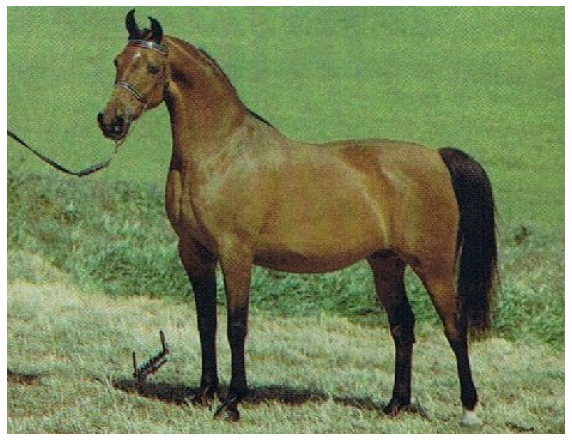

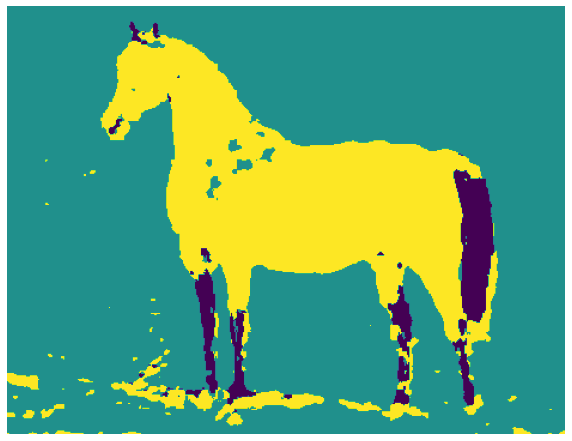

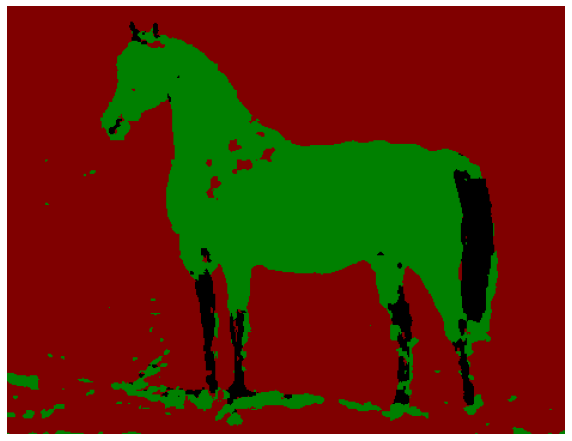


Image: 001707.jpg


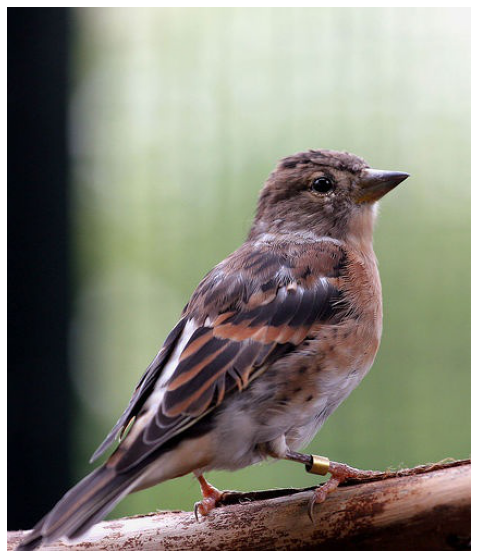

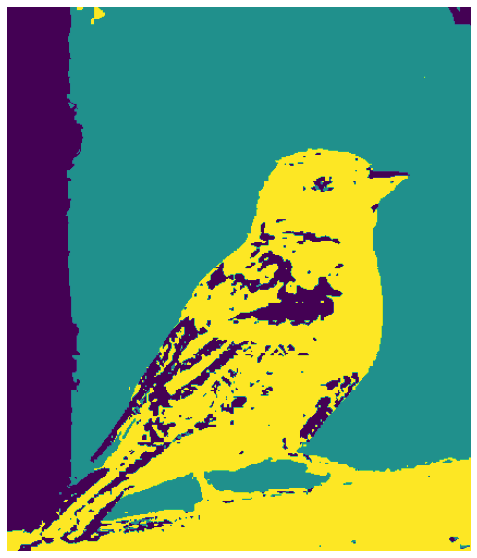

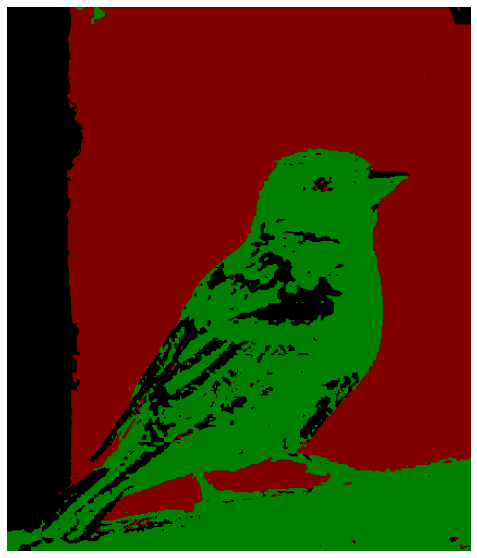


Image: 001950.jpg


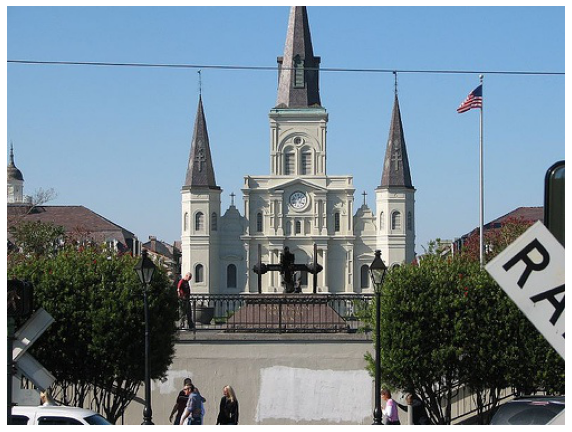

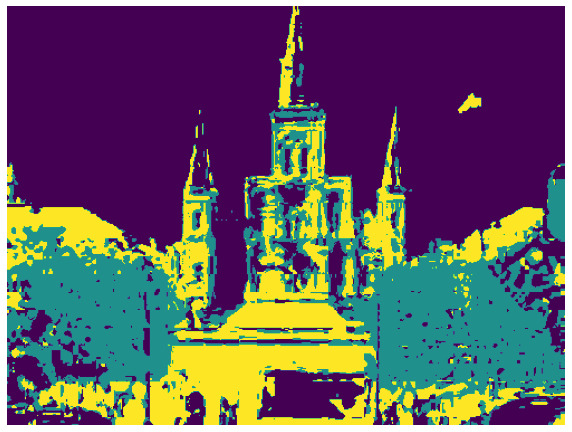

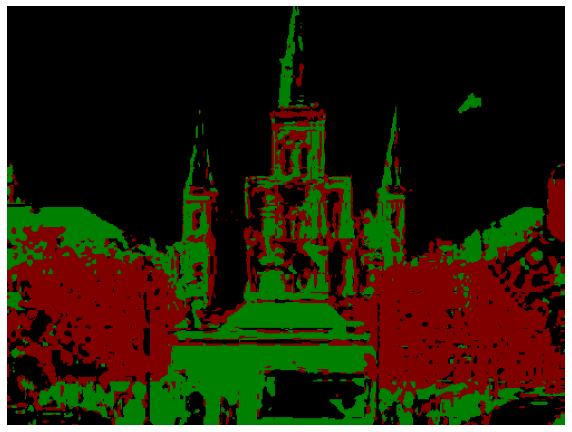

In [ ]:
import imageio

def decode_segmap(image,colors,nc=21):
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = colors[l][0]
    g[idx] = colors[l][1]
    b[idx] = colors[l][2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb
  
def image(img_path):
  img=cv2.imread(img_path,cv2.IMREAD_COLOR)
  img= torch.tensor(img)
  image = torch.argmax(img.squeeze(), dim=2).detach().cpu().numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.axis('off')
  return image


image_list = ['000347','001707','001950']
for img in image_list:
  print(f'\nImage: {img}.jpg')
  plt.figure(figsize=(10, 10))
  plt.imshow(imageio.imread('./VOCdevkit/VOC2007/JPEGImages/'+img+'.jpg'))
  plt.axis('off')
  plt.show()

  rgb = decode_segmap(image('./VOCdevkit/VOC2007/JPEGImages/'+img+'.jpg'),VOC_COLORMAP)
  plt.figure(figsize=(10, 10))
  plt.imshow(rgb)
  plt.axis('off')
  plt.show()

## Properties of Segmentation Model:

Semantic segmentation aims to identify each pixel in the input image with the appropriate class that represents a particular item. The Fully Convolutional Network (FCN), which stacks several convolutional layers with comparable padding to retain dimension, is one method for segmentation.

Convolution: A segmented map is produced by the model's several convolutional layers, which extract information from an input picture of any size.

Pooling: The resolution of complicated features is decreased by pooling, which also lowers the computing load. This aids in lowering noise levels while obtaining dominant features.

Upsampling: increases the input image's resolution, allowing the algorithm to produce more precise predictions.

Skip Connections: A FCN's resolution is decreased by downsampling, and when it is upsampled, producing fine details is challenging. Thus, skip connections provide the layers enough data to construct more precise segmentation borders or accurate spatial organization.

Evaluation Metric(IOU) for Segmentation Model:

The Jaccard Index, or IOU, is calculated by dividing the area of union between the anticipated segmentation and the ground truth by the amount of overlap between the two. IOU has a range of 0 to 1, with 0 denoting no overlap and 1 denoting flawless overlap segmentation.

The mean IOU of the picture is determined for binary or multi-class segmentation by averaging the IOU of each class.